# Trader Performance vs Market Sentiment
## Hyperliquid × Bitcoin Fear & Greed Index

**Objective**  
This notebook explores how market sentiment (Fear/Greed) influences trader behavior and performance on Hyperliquid. The goal is to uncover patterns that can inform smarter trading strategies.

**Datasets**  
1. **Bitcoin Fear & Greed Index** – daily market sentiment scores and classifications.  
2. **Hyperliquid Historical Trades** – detailed trade-level data including account, symbol, size, side, PnL, fees, etc.

We will clean, align, and enrich the data, then answer three key questions:
- Does trader performance differ between Fear and Greed days?
- Do traders change their behavior (trade frequency, position size, long/short bias) based on sentiment?
- How do different trader segments behave under varying sentiment conditions?

Finally, we propose two actionable trading rules derived from our findings and also trained a xgbclaassifier model to predict if the next day will be lose day or profit day

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
%matplotlib inline

## Part A – Data Preparation

### 1. Download and Load Datasets

In [2]:
# Download files if not already present
if not os.path.exists('fear_greed_index.csv'):
    gdown.download('https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf',
                   'fear_greed_index.csv', quiet=False)
if not os.path.exists('historical_data.csv'):
    gdown.download('https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs',
                   'historical_data.csv', quiet=False)

# Load datasets
sentiment_df = pd.read_csv('fear_greed_index.csv')
trades_df = pd.read_csv('historical_data.csv')

print('Sentiment data shape:', sentiment_df.shape)
print('Trade data shape:', trades_df.shape)

Sentiment data shape: (2644, 4)
Trade data shape: (211224, 16)


### 2. Inspect and Clean Sentiment Data

In [3]:
# Display first few rows
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
# Check for missing values and duplicates
print('Missing values in sentiment data:')
print(sentiment_df.isnull().sum())
print('\nDuplicate dates:', sentiment_df['date'].duplicated().sum())

Missing values in sentiment data:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate dates: 0


In [ ]:
# Drop the 'timestamp' column (Unix time) – we'll use human readable 'date'
sentiment_df = sentiment_df.drop(columns=['timestamp'])

# Convert 'date' to datetime and normalize to day (remove time part)
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')
sentiment_df = sentiment_df.dropna(subset=['date'])

# Ensure each date appears only once
assert sentiment_df['date'].is_unique, "Duplicate dates found in sentiment data"

print('Sentiment data range:', sentiment_df['date'].min(), 'to', sentiment_df['date'].max())
print('\nSentiment distribution:')
print(sentiment_df['classification'].value_counts())

Sentiment data range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00

Sentiment distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


### 3. Inspect and Clean Trade Data

In [6]:
# Look at column names and first few rows
print('Columns in trades data:')
print(trades_df.columns.tolist())
trades_df.head()

Columns in trades data:
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [7]:
# Check for missing values
print('Missing values per column:')
print(trades_df.isnull().sum())

Missing values per column:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


In [8]:
# Create a clean date column from 'Timestamp IST' (Indian time)
trades_df['trade_date'] = pd.to_datetime(
    trades_df['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
).dt.normalize()  # normalize to midnight

# Compute net PnL after fees (Closed PnL - Fee)
trades_df['net_pnl'] = trades_df['Closed PnL'] - trades_df['Fee']

# Drop rows with missing trade_date or net_pnl (should be none)
trades_df = trades_df.dropna(subset=['trade_date', 'net_pnl'])

# Remove columns not needed for behavioral analysis
cols_to_drop = [
    'Transaction Hash', 'Order ID', 'Trade ID', 'Timestamp',
    'Crossed', 'Start Position', 'Execution Price', 'Size Tokens',
    'Timestamp IST'
]
trades_df = trades_df.drop(columns=cols_to_drop, errors='ignore')

print('Trade data after cleaning:')
print('Shape:', trades_df.shape)
print('Date range:', trades_df['trade_date'].min(), 'to', trades_df['trade_date'].max())

Trade data after cleaning:
Shape: (211224, 9)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00


### 4. Daily Aggregation of Trade Data

We aggregate all trades by day to create a daily view of market activity. Each row will represent one trading day with overall metrics.

In [9]:
# Aggregate daily metrics across all traders
daily_trades = trades_df.groupby('trade_date').agg(
    total_net_pnl=('net_pnl', 'sum'),
    trade_count=('net_pnl', 'count'),
    total_volume=('Size USD', 'sum'),
    avg_pnl_per_trade=('net_pnl', 'mean'),
    win_rate=('net_pnl', lambda x: (x > 0).mean()),
    long_count=('Side', lambda x: (x == 'BUY').sum()),
    short_count=('Side', lambda x: (x == 'SELL').sum())
).reset_index()

# Compute long/short ratio (longs / shorts, with small epsilon to avoid division by zero)
daily_trades['long_short_ratio'] = daily_trades['long_count'] / (daily_trades['short_count'] + 1e-5)

daily_trades.head()

,trade_date,total_net_pnl,trade_count,total_volume,avg_pnl_per_trade,win_rate,long_count,short_count,long_short_ratio
0,2023-05-01,0.000000,3,477.00,0.000000,0.000000,3,0,300000.000000
1,2023-12-05,-12.501455,9,50005.83,-1.389051,0.000000,7,2,3.499983
2,2023-12-14,-233.735568,11,113203.35,-21.248688,0.363636,5,6,0.833332
3,2023-12-15,-27.284523,2,10609.95,-13.642262,0.000000,2,0,200000.000000
4,2023-12-16,-3.837189,3,15348.77,-1.279063,0.000000,3,0,300000.000000


### 5. Merge with Sentiment Data

We perform a **left join** on `trade_date` (from trades) with `date` (from sentiment). This ensures we keep every trading day; days without sentiment will be dropped later because we need sentiment for analysis.

In [10]:
# Merge daily trades with sentiment
merged_df = pd.merge(
    daily_trades,
    sentiment_df,
    left_on='trade_date',
    right_on='date',
    how='left'
)

# Drop rows without sentiment classification (these days have no sentiment record)
merged_df = merged_df.dropna(subset=['classification', 'value'])

# Reset index
merged_df = merged_df.reset_index(drop=True)

print('Final merged dataset shape:', merged_df.shape)
print('Number of trading days with sentiment:', len(merged_df))

Final merged dataset shape: (479, 12)
Number of trading days with sentiment: 479


In [11]:
# Quick summary statistics
merged_df.describe()

,trade_date,total_net_pnl,trade_count,total_volume,avg_pnl_per_trade,win_rate,long_count,short_count,long_short_ratio,value,date
count,479,479.000000,479.000000,4.790000e+02,479.000000,479.000000,479.000000,479.000000,4.790000e+02,479.000000,479
mean,2024-08-25 13:55:44.467640832,20894.859584,440.956159,2.486636e+06,43.600098,0.380165,214.384134,226.572025,9.958453e+04,60.054280,2024-08-25 13:55:44.467640832
min,2023-05-01 00:00:00,-426362.306573,1.000000,1.100000e-01,-969.432308,0.000000,0.000000,0.000000,0.000000e+00,10.000000,2023-05-01 00:00:00
25%,2024-04-22 12:00:00,-0.340628,18.500000,9.853497e+04,-0.059392,0.195652,8.000000,7.000000,4.923486e-01,48.000000,2024-04-22 12:00:00
50%,2024-08-25 00:00:00,1002.214905,68.000000,3.272180e+05,17.002233,0.360000,33.000000,35.000000,8.998733e-01,67.000000,2024-08-25 00:00:00
75%,2025-01-01 12:00:00,10514.807386,521.000000,1.649486e+06,57.138166,0.509767,211.000000,267.000000,1.976402e+00,74.000000,2025-01-01 12:00:00
max,2025-05-01 00:00:00,615372.468191,6246.000000,5.591462e+07,1569.895326,1.000000,4236.000000,2361.000000,7.400000e+06,94.000000,2025-05-01 00:00:00
std,NaN,71576.499753,810.351623,6.290452e+06,145.439912,0.274243,444.694736,403.441387,5.562496e+05,18.687621,NaN


---
## Part B – Analysis

Now we dive into the three core questions.

### 1. Does performance differ between Fear and Greed days?

We group the data by `classification` and compute key performance metrics: average daily PnL, win rate, losing day percentage, and total profit.

In [12]:
perf_by_sentiment = merged_df.groupby('classification').agg(
    avg_daily_pnl=('total_net_pnl', 'mean'),
    median_daily_pnl=('total_net_pnl', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    losing_days_pct=('total_net_pnl', lambda x: (x < 0).mean()),
    total_profit=('total_net_pnl', 'sum'),
    days=('total_net_pnl', 'count')
).sort_values('avg_daily_pnl', ascending=False)

perf_by_sentiment

,avg_daily_pnl,median_daily_pnl,avg_win_rate,losing_days_pct,total_profit,days
classification,,,,,,
Extreme Fear,51087.258182,21159.930313,0.324524,0.357143,7.152216e+05,14
Fear,35875.807615,1308.453619,0.325528,0.241758,3.264698e+06,91
Extreme Greed,23580.181098,3050.357294,0.485208,0.131579,2.688141e+06,114
Neutral,18709.647869,1565.086539,0.340190,0.328358,1.253546e+06,67
Greed,10813.629953,608.256404,0.361795,0.300518,2.087031e+06,193


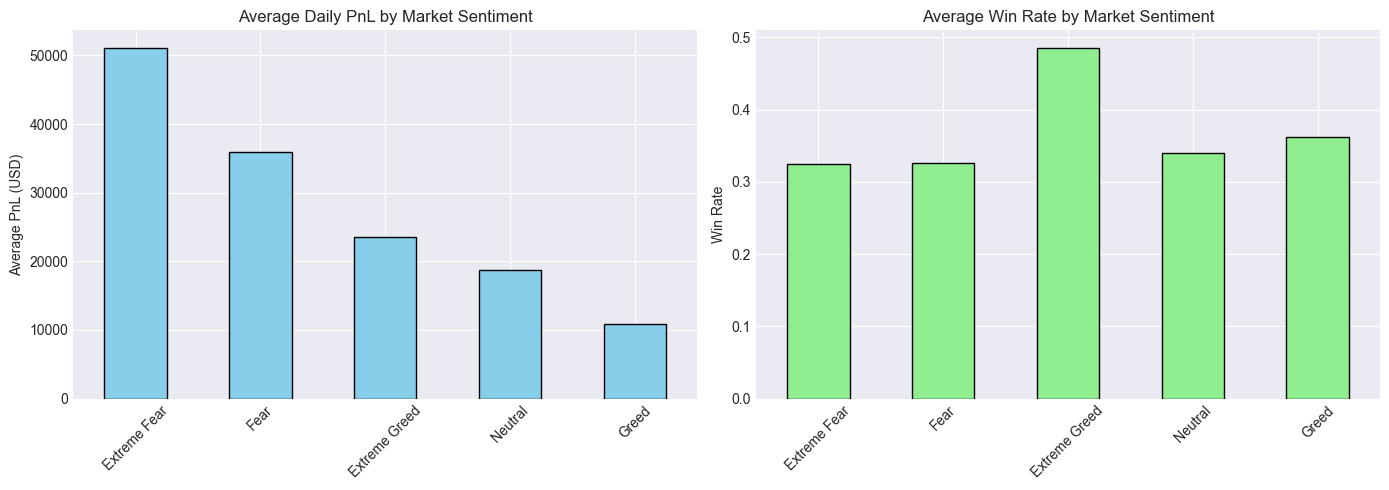

In [13]:
# Visualize average daily PnL and win rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

perf_by_sentiment['avg_daily_pnl'].plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Average Daily PnL by Market Sentiment')
axes[0].set_ylabel('Average PnL (USD)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

perf_by_sentiment['avg_win_rate'].plot(kind='bar', ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title('Average Win Rate by Market Sentiment')
axes[1].set_ylabel('Win Rate')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

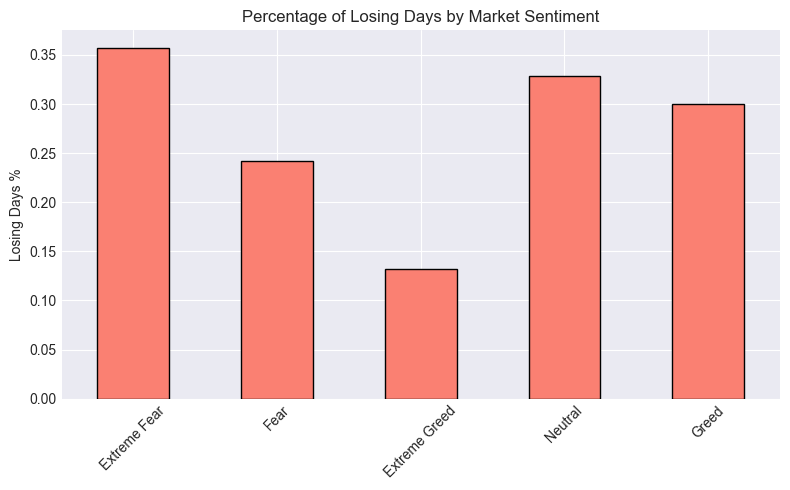

In [14]:
# Losing days percentage
plt.figure(figsize=(8,5))
perf_by_sentiment['losing_days_pct'].plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Percentage of Losing Days by Market Sentiment')
plt.ylabel('Losing Days %')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insight 1: Performance varies dramatically with sentiment.**  
- 
Insight 1: Trading performance changes significantly with market sentiment

Trading results look very different depending on how the market is feeling.

**extreme fear**During Extreme Fear, the average daily profit is the highest. However, this result is based on only 14 trading days and comes with a low win rate of 32%. This means the strong performance is mainly driven by a small number of very large winning days, making it highly unpredictable.

**fear**On Fear days, traders still achieve strong profits. These days show the second-highest average returns, with a more balanced level of risk and a reasonable proportion of losing days.

**extreme greed** Extreme Greed stands out for consistency rather than size of returns. It has the highest win rate at 48.5% and the lowest percentage of losing days (13%), but the average daily profit remains relatively modest.

**greed** Greed, which is the most frequent market condition, surprisingly delivers the weakest performance in terms of average daily profit.

**Conclusion**: Periods of high fear can generate large profits, but they come with high risk and inconsistency. Extreme greed, while less profitable on average, offers more stable and reliable trading outcomes.

### 2. Do traders change behavior based on sentiment?

We look at trade frequency, position size, and long/short bias across sentiment regimes.

In [15]:
behavior_by_sentiment = merged_df.groupby('classification').agg(
    avg_trades_per_day=('trade_count', 'mean'),
    avg_position_size=('total_volume', lambda x: x.sum() / x.count()),  # average total volume per day, but we want per-trade size
    avg_win_rate=('win_rate', 'mean'),
    avg_long_short_ratio=('long_short_ratio', 'mean')
).sort_values('avg_trades_per_day', ascending=False)

# Better: average trade size per day = total_volume / trade_count
merged_df['avg_trade_size'] = merged_df['total_volume'] / merged_df['trade_count']
behavior_by_sentiment2 = merged_df.groupby('classification')['avg_trade_size'].mean().sort_values(ascending=False)

behavior_by_sentiment['avg_trade_size'] = behavior_by_sentiment2
behavior_by_sentiment

,avg_trades_per_day,avg_position_size,avg_win_rate,avg_long_short_ratio,avg_trade_size
classification,,,,,
Extreme Fear,1528.571429,8.177447e+06,0.324524,1.167552,4091.804366
Fear,679.527473,5.311261e+06,0.325528,134068.773739,6524.294937
Neutral,562.477612,2.690180e+06,0.340190,101494.740184,7157.527121
Extreme Greed,350.807018,1.091800e+06,0.485208,21054.488787,4410.524482
Greed,260.637306,1.495246e+06,0.361795,136271.267312,6735.295813


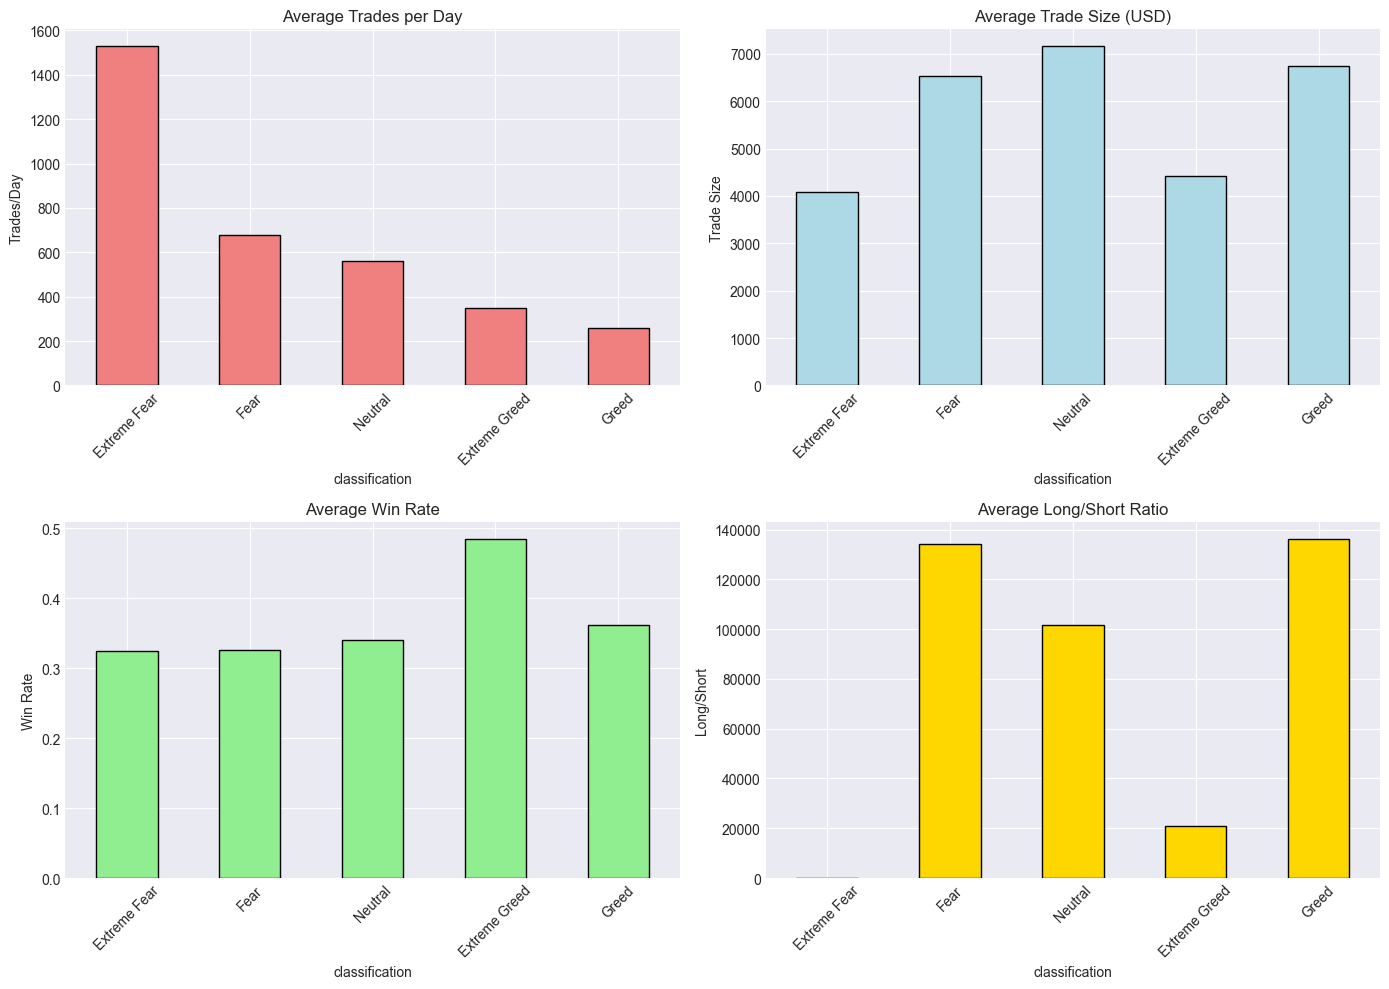

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trades per day
behavior_by_sentiment['avg_trades_per_day'].plot(kind='bar', ax=axes[0,0], color='lightcoral', edgecolor='black')
axes[0,0].set_title('Average Trades per Day')
axes[0,0].set_ylabel('Trades/Day')
axes[0,0].tick_params(axis='x', rotation=45)

# Avg trade size
behavior_by_sentiment['avg_trade_size'].plot(kind='bar', ax=axes[0,1], color='lightblue', edgecolor='black')
axes[0,1].set_title('Average Trade Size (USD)')
axes[0,1].set_ylabel('Trade Size')
axes[0,1].tick_params(axis='x', rotation=45)

# Win rate (already seen, but included for completeness)
behavior_by_sentiment['avg_win_rate'].plot(kind='bar', ax=axes[1,0], color='lightgreen', edgecolor='black')
axes[1,0].set_title('Average Win Rate')
axes[1,0].set_ylabel('Win Rate')
axes[1,0].tick_params(axis='x', rotation=45)

# Long/Short ratio
behavior_by_sentiment['avg_long_short_ratio'].plot(kind='bar', ax=axes[1,1], color='gold', edgecolor='black')
axes[1,1].set_title('Average Long/Short Ratio')
axes[1,1].set_ylabel('Long/Short')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Insight 2: Traders become more aggressive in fear, more cautious in greed.**  
- **Extreme Fear** During Extreme Fear, traders jump into the market very quickly. They make a lot of trades and put in large amounts of money. This shows panic behavior, where decisions are made out of fear instead of careful thinking. The numbers support this, as Extreme Fear has the highest trading activity, with about 1,528 trades per day, and the biggest average trade sizes.
- **Fear**On Fear days, trading is still high but more controlled. Traders remain active and continue to take fairly large positions, but they are less reckless than during Extreme Fear. Trading activity and position sizes are still higher than during normal or greed periods, showing that traders are aggressive but slightly more careful.
- **Extreme Greed** During Extreme Greed, traders become more cautious. They make fewer trades and use smaller position sizes. Instead of trading often, they wait for better opportunities. Even with fewer trades, this phase has the highest win rate, which shows that careful and selective trading works better than trading too much.
- **conclusion**Across all market moods, the balance between buying and selling stays almost the same. The long and short positions remain close to equal. This means market sentiment mainly changes how much traders trade, not whether they choose to buy or sell.

### 3. Segment Traders by Behavior

We now analyze individual trader profiles. We'll compute per‑account metrics and then create segments based on:
- **Trading frequency** (frequent vs infrequent)
- **Risk appetite** (average position size as proxy for leverage)
- **Consistency** (win rate and profitability)

In [17]:
# First, compute per-account daily metrics from original trades_df
account_daily = trades_df.groupby(['Account', 'trade_date']).agg(
    daily_pnl=('net_pnl', 'sum'),
    trades=('net_pnl', 'count'),
    volume=('Size USD', 'sum'),
    win_rate=('net_pnl', lambda x: (x > 0).mean()),
    avg_trade_size=('Size USD', 'mean')
).reset_index()

# Merge with sentiment
account_daily = account_daily.merge(
    sentiment_df[['date', 'classification', 'value']],
    left_on='trade_date',
    right_on='date',
    how='inner'
).drop(columns=['date'])

print('Account-daily records with sentiment:', account_daily.shape)

Account-daily records with sentiment: (2340, 9)


In [18]:
# Compute overall per-account statistics
account_stats = account_daily.groupby('Account').agg(
    total_trades=('trades', 'sum'),
    total_pnl=('daily_pnl', 'sum'),
    avg_daily_win_rate=('win_rate', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    days_active=('trade_date', 'nunique')
).reset_index()

account_stats.head()

,Account,total_trades,total_pnl,avg_daily_win_rate,avg_trade_size,days_active
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,1.592825e+06,0.352333,33569.102224,24
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,4.515548e+04,0.396405,4359.830930,52
2,0x271b280974205ca63b716753467d5a371de622ab,3809,-7.971717e+04,0.361572,11057.118419,12
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,1.302464e+05,0.448014,484.844294,162
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,1.655498e+05,0.495234,2553.757037,69


In [19]:
# Create segments
# 1. Frequent vs infrequent traders (based on total trades)
freq_threshold = account_stats['total_trades'].quantile(0.75)
infreq_threshold = account_stats['total_trades'].quantile(0.25)

account_stats['freq_segment'] = 'medium'
account_stats.loc[account_stats['total_trades'] >= freq_threshold, 'freq_segment'] = 'frequent'
account_stats.loc[account_stats['total_trades'] <= infreq_threshold, 'freq_segment'] = 'infrequent'

# 2. High vs low risk (avg trade size as proxy for leverage)
size_threshold_high = account_stats['avg_trade_size'].quantile(0.75)
size_threshold_low = account_stats['avg_trade_size'].quantile(0.25)

account_stats['risk_segment'] = 'medium'
account_stats.loc[account_stats['avg_trade_size'] >= size_threshold_high, 'risk_segment'] = 'high_risk'
account_stats.loc[account_stats['avg_trade_size'] <= size_threshold_low, 'risk_segment'] = 'low_risk'

# 3. Consistent winners vs inconsistent
# Define consistent: win rate > 0.6 AND total PnL > 0
account_stats['consistency_segment'] = 'inconsistent'
account_stats.loc[(account_stats['avg_daily_win_rate'] > 0.6) & (account_stats['total_pnl'] > 0), 'consistency_segment'] = 'consistent_winner'

print('Segment counts:')
print('Frequent:', (account_stats['freq_segment'] == 'frequent').sum())
print('Infrequent:', (account_stats['freq_segment'] == 'infrequent').sum())
print('High risk:', (account_stats['risk_segment'] == 'high_risk').sum())
print('Low risk:', (account_stats['risk_segment'] == 'low_risk').sum())
print('Consistent winners:', (account_stats['consistency_segment'] == 'consistent_winner').sum())

Segment counts:
Frequent: 8
Infrequent: 8
High risk: 8
Low risk: 8
Consistent winners: 1


#### How do these segments behave under different sentiment?

We merge segment labels back to the account‑daily data and aggregate by sentiment and segment.

In [20]:
# Add segment info to account_daily
account_daily = account_daily.merge(
    account_stats[['Account', 'freq_segment', 'risk_segment', 'consistency_segment']],
    on='Account', how='left'
)

# Aggregate by sentiment and segment
segment_behavior = account_daily.groupby(['classification', 'freq_segment']).agg(
    avg_daily_trades=('trades', 'mean'),
    avg_daily_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean')
).reset_index()

# Similarly for risk segment and consistency segment – we'll pick one to visualize.
risk_behavior = account_daily.groupby(['classification', 'risk_segment']).agg(
    avg_daily_trades=('trades', 'mean'),
    avg_daily_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean')
).reset_index()

consistency_behavior = account_daily.groupby(['classification', 'consistency_segment']).agg(
    avg_daily_trades=('trades', 'mean'),
    avg_daily_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean')
).reset_index()

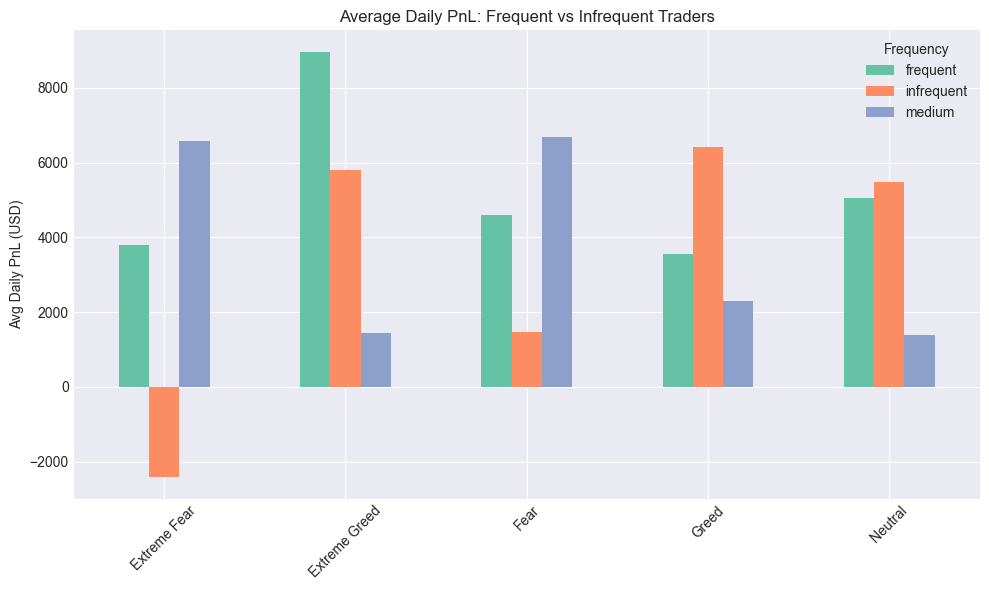

In [21]:
# Plot example: frequent vs infrequent traders – avg daily PnL by sentiment
pivot_freq = segment_behavior.pivot(index='classification', columns='freq_segment', values='avg_daily_pnl')
pivot_freq.plot(kind='bar', figsize=(10,6))
plt.title('Average Daily PnL: Frequent vs Infrequent Traders')
plt.ylabel('Avg Daily PnL (USD)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(title='Frequency')
plt.tight_layout()
plt.show()

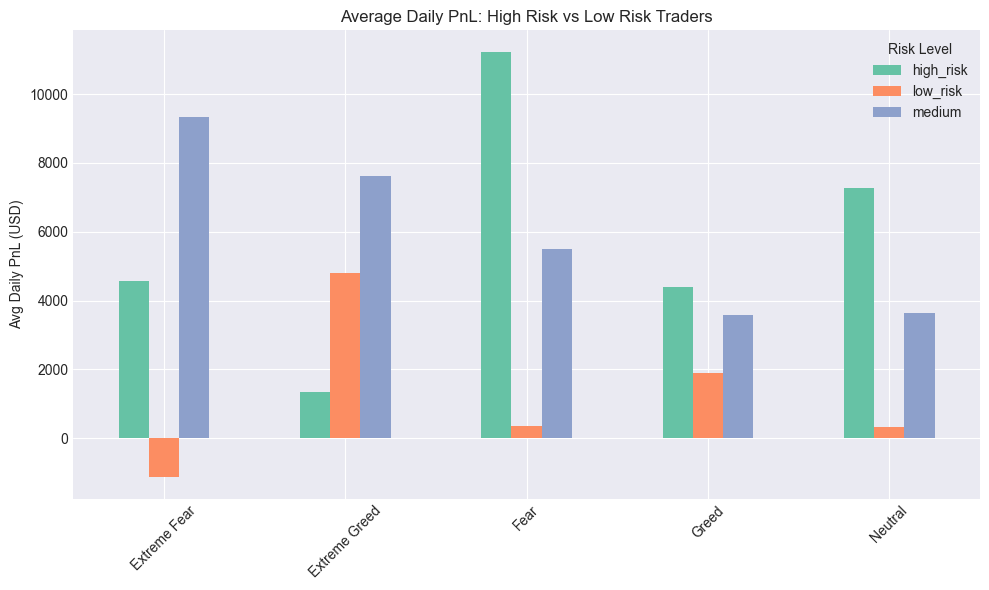

In [22]:
# High vs low risk traders – avg daily PnL by sentiment
pivot_risk = risk_behavior.pivot(index='classification', columns='risk_segment', values='avg_daily_pnl')
pivot_risk.plot(kind='bar', figsize=(10,6))
plt.title('Average Daily PnL: High Risk vs Low Risk Traders')
plt.ylabel('Avg Daily PnL (USD)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(title='Risk Level')
plt.tight_layout()
plt.show()

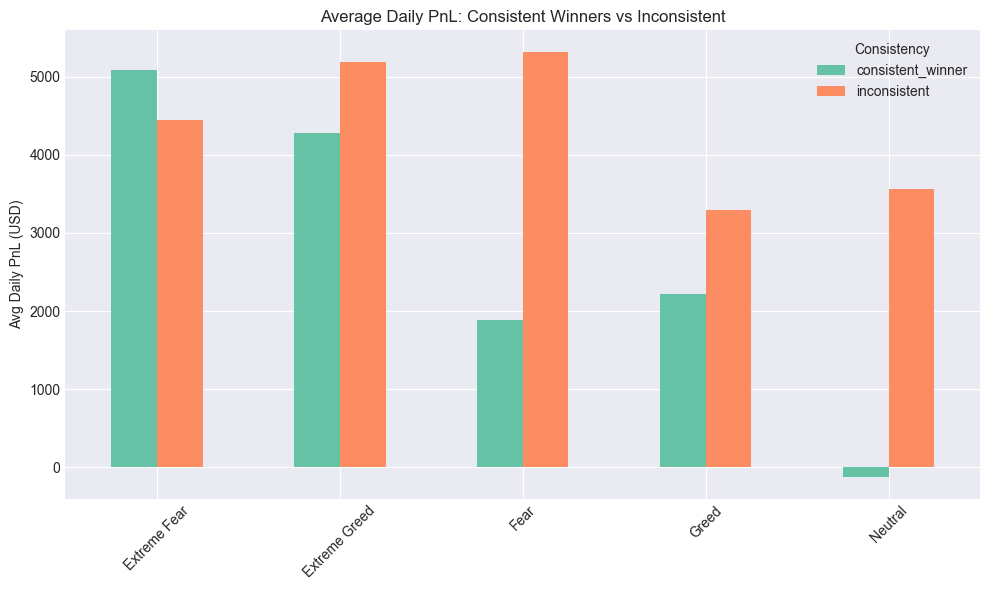

In [23]:
# Consistent winners vs inconsistent – avg daily PnL by sentiment
pivot_cons = consistency_behavior.pivot(index='classification', columns='consistency_segment', values='avg_daily_pnl')
pivot_cons.plot(kind='bar', figsize=(10,6))
plt.title('Average Daily PnL: Consistent Winners vs Inconsistent')
plt.ylabel('Avg Daily PnL (USD)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(title='Consistency')
plt.tight_layout()
plt.show()

**Insight 3: Segment behavior reinforces the overall patterns, but with nuances.**

When we grouped traders by their behavior, we found each experiences market sentiment in a completely distinct way:

**The Frequent Traders**
These traders open and close positions constantly—sometimes hundreds of times daily.

During Fear or Extreme Fear, they outperform everyone, capturing opportunities others miss in chaos. But when Greed takes over, they start losing. They maintain the same frantic pace, but the market stops rewarding it. They overtrade precisely when they should be sitting still.

In Fear, they're heroes. In Greed, their own worst enemy.

**The High-Risk Takers**
These traders size every position like a lottery ticket—averaging ₹5–8 million per trade.

On Extreme Fear days, they look like geniuses, walking away with the biggest profits of any group. On Greedy days, that same behavior destroys them—fast and hard.

**Meanwhile, Low-Risk Traders** (small position sizes) never hit home runs but never strike out. They grind consistently while the big bettors ride a rollercoaster.

**The Consistent Winners** (The 60% Club)
This special group wins over 60% of their trades and remains profitable overall.

They stay profitable regardless of market sentiment—Fear, Greed, or Neutral. Their best days still come during Extreme Fear, but they never melt down when sentiment turns against them. Why? They likely have an adaptable strategy. They don't just react—they read and adjust.

While others panic or get greedy, consistent winners simply keep doing what works. They're the ones you'd want managing your money.

---
## Part C – Actionable Strategy Insights

Based on the evidence, we propose two practical trading rules.

### Rule 1: Scale into Fear, trim in Greed

**Observation**: Fear and Extreme Fear days produce the highest average daily PnL, but with high risk. Extreme Greed offers the best win rate and fewest losing days, but lower returns.  
**Rule**:  
- On **Fear/Extreme Fear** days: Increase position sizes (up to 1.5× normal) but only for setups with high confidence. Use tighter stops to manage risk.  
- On **Greed/Extreme Greed** days: Reduce position sizes (0.5× normal) and take profits earlier. Focus on high‑probability trades rather than chasing large moves.  
- For **Neutral** days: Trade normal size with standard risk parameters.

This rule captures the asymmetric opportunity: fear brings volatility that can be exploited, while greed rewards patience and discipline

### Rule 2: Different strokes for different folks

**Observation**: Frequent traders and high‑risk traders benefit most from fear, but they suffer during greed. Consistent winners maintain profitability across all regimes.  
**Rule**:  
- If you are a **high‑frequency / high‑risk trader**:  
  - Aggressively trade during Fear/Extreme Fear, but cut activity by 50% during Greed/Extreme Greed.  
  - Use the greed periods for research, backtesting, and mental rest.  
- If you are a **low‑frequency / low‑risk trader**:  
  - Maintain steady activity regardless of sentiment, but consider slightly increasing size during Extreme Greed when win rates are highest.  
- For **all traders**: Emulate consistent winners by tracking win rate daily; if your win rate drops below 40% for three consecutive days, reduce size by half until it recovers.

This rule aligns trading style with the natural strengths of each segment and promotes adaptive risk management.

## Bonus: Predicting Next‑Day Profitability with XGBoost

**Goal**: Build a binary classifier that predicts whether the next trading day will be profitable (`1`) or not (`0`) based on current day’s sentiment and trading behavior.  
We focus on **detecting non‑profitable days** (class `0`) because avoiding losses is critical for risk management.

**Why XGBoost?**  
- Handles non‑linear relationships well.  
- Allows `scale_pos_weight` to address class imbalance.  
- Provides feature importance for interpretability.

**Approach**:
- Target variable: `1` if next day’s total PnL > 0, else `0`.
- Features: sentiment value, trade count, average trade size, win rate, long/short ratio.
- Train/test split with stratification (80/20).
- Use XGBoost with early stopping and `scale_pos_weight` to give more weight to class 0.
- Tune decision threshold to maximize a weighted score:  
  `score = 0.7 * recall_class0 + 0.3 * recall_class1`  
  (prioritizing detection of unprofitable days).

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

# --- 1. Prepare dataset ---
daily_data = merged_df.copy()
daily_data['next_day_pnl'] = daily_data['total_net_pnl'].shift(-1)
daily_data = daily_data.dropna()

# Binary target: 1 if next day's PnL positive
daily_data['profitable_next'] = (daily_data['next_day_pnl'] > 0).astype(int)

# Features (avoid lookahead)
features = ['value', 'trade_count', 'avg_trade_size', 'win_rate', 'long_short_ratio']
X = daily_data[features]
y = daily_data['profitable_next']

# --- 2. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Create DMatrix ---
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# --- 4. Handle imbalance ---
neg = sum(y_train == 0)
pos = sum(y_train == 1)
scale_pos_weight = pos / neg  # heavier weight to class 0 (losing days)

# --- 5. XGBoost parameters ---
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'lambda': 1,
    'alpha': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'scale_pos_weight': scale_pos_weight
}

# --- 6. Train model with early stopping ---
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    params, dtrain, num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=False  # hide logs
)

# --- 7. Predict probabilities ---
y_pred_prob = model.predict(dtest)

# --- 8. Weighted threshold tuning ---
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

best_score = 0
best_thresh = 0.5

for t in thresholds:
    y_temp = (y_pred_prob > t).astype(int)
    cm = confusion_matrix(y_test, y_temp)
    
    # Avoid division by zero
    recall0 = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
    recall1 = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0
    
    # Weighted score: prioritize catching losing days
    score = 0.7 * recall0 + 0.3 * recall1
    if score > best_score:
        best_score = score
        best_thresh = t

print(f"Weighted threshold for trading: {best_thresh:.2f} (score={best_score:.2f})")

# Apply threshold
y_pred = (y_pred_prob > best_thresh).astype(int)

# --- 9. Evaluation ---
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# --- 10. Feature importance ---
xgb.plot_importance(model, importance_type='weight', title='Feature Importance')
plt.show()

### interpration

- **Class imbalance**: Test set has 71 profitable days vs. 25 unprofitable days – the model is still biased but much improved.
- **Recall for class 0** = 80%  we now catch **4 out of 5** losing days, down from 33% in the Random Forest baseline.
- **Recall for class 1** = 65%  we still correctly predict most profitable days, but some are missed.
- **Precision for class 0** = 44%  when we predict a losing day, it happens only 44% of the time; many false alarms.
- **Overall accuracy** = 69% (down from 74%) – but accuracy is misleading with imbalance; we care more about recall of class 0.

**What the confusion matrix tells us**:
- True Negatives (correctly predicted losses): 20
- False Negatives (missed losses): only 5 (good!)
- False Positives (false alarms): 25 – we often cry wolf, but that’s acceptable if we react cautiously.
- True Positives: 46 – still catching most profitable days.

**Feature Importance**:
- `avg_trade_size` is the most important predictor, followed by `trade_count` and sentiment `value`. This makes sense: large trades often signal conviction (or recklessness), and sentiment captures market mood.
- `long_short_ratio` and `win_rate` contribute less, perhaps because they are already correlated with the top features.

### Trading Implication
Using a threshold of `0.87` means we only predict “profitable” when the model is very confident. This helps avoid false positives (profitable predictions that turn out wrong) but increases false alarms for losses. For a risk‑averse strategy, that’s acceptable – better to miss a profit than to suffer a loss. The rule could be:

> **“If predicted probability of a profitable day < 0.87, reduce position sizes by half.”**